# Parte I - Importar Libs

In [1]:
import numpy as np
import sqlite3 as sql
from tqdm import tqdm
import glob
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV, f_classif, chi2

from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
!pip install boruta
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from boruta import BorutaPy
from sklearn.metrics import roc_auc_score

import folium
from folium import plugins

  Using cached Boruta-0.3-py3-none-any.whl (56 kB)


ModuleNotFoundError: No module named 'folium'

# Carregar DataFrame

In [4]:
# Importar Planilha do Arquivos
Focos_Anual = pd.read_csv('Focos_Anual.csv')

In [5]:
Focos_Anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91245 entries, 0 to 91244
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          91245 non-null  object 
 1   month         91245 non-null  int64  
 2   year          91245 non-null  int64  
 3   pais          91245 non-null  object 
 4   estado        91245 non-null  object 
 5   municipio     91245 non-null  object 
 6   diasemchuva   62964 non-null  float64
 7   precipitacao  62964 non-null  float64
 8   riscofogo     62964 non-null  float64
 9   latitude      91245 non-null  float64
 10  longitude     91245 non-null  float64
 11  frp           41722 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 8.4+ MB


# Limpeza de Dados

In [6]:
# Checando quantos anos tem
Focos_Anual['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021], dtype=int64)

In [7]:
# Verificando o percentual de valores nulos
print(f'Temos os seguintes percentuais de valores nulos: \n{(Focos_Anual.isnull().sum()/Focos_Anual.shape[0])*100}')

Temos os seguintes percentuais de valores nulos: 
date             0.000000
month            0.000000
year             0.000000
pais             0.000000
estado           0.000000
municipio        0.000000
diasemchuva     30.994575
precipitacao    30.994575
riscofogo       30.994575
latitude         0.000000
longitude        0.000000
frp             54.274755
dtype: float64


### Linhas Duplicadas

In [8]:
# análise de duplicatas
Focos_Anual.duplicated().sum()

0

### Remoçaõ de Colunas Constantes

In [9]:
# Remoção de Colunas Constantes
colunas_constantes = []
for col in Focos_Anual.columns:
    if len(Focos_Anual[col].unique()) == 1:
        colunas_constantes.append(col)
    else:
        print(f'{col} OK')

date OK
month OK
year OK
estado OK
municipio OK
diasemchuva OK
precipitacao OK
riscofogo OK
latitude OK
longitude OK
frp OK


In [10]:
Focos_Anual

,date,month,year,pais,estado,municipio,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,2010-01-04,1,2010,Brasil,MATO GROSSO DO SUL,CORUMBA,NaN,NaN,NaN,-18.091,-55.493,NaN
1,2010-01-05,1,2010,Brasil,MATO GROSSO,BARAO DE MELGACO,NaN,NaN,NaN,-16.753,-55.682,NaN
2,2010-01-06,1,2010,Brasil,MATO GROSSO DO SUL,CORUMBA,NaN,NaN,NaN,-20.302,-57.240,NaN
3,2010-01-06,1,2010,Brasil,MATO GROSSO DO SUL,CORUMBA,NaN,NaN,NaN,-19.595,-57.104,NaN
4,2010-01-06,1,2010,Brasil,MATO GROSSO DO SUL,SONORA,NaN,NaN,NaN,-17.644,-55.086,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91240,2021-01-26,1,2021,Brasil,MATO GROSSO,POCONE,1.0,13.4,0.0,-17.491,-56.899,38.1
91241,2021-01-29,1,2021,Brasil,MATO GROSSO DO SUL,MIRANDA,1.0,1.2,0.0,-20.106,-56.571,5.8
91242,2021-02-01,2,2021,Brasil,MATO GROSSO,CACERES,1.0,1.9,0.0,-16.589,-57.538,21.4
91243,2021-02-09,2,2021,Brasil,MATO GROSSO DO SUL,CORUMBA,5.0,0.0,0.2,-18.555,-55.733,14.5


In [11]:
# Dados Temperatura Cidades
Cidades_Pantanal = pd.read_csv('Cidades_Pantanal.txt',delimiter = "\t")

In [12]:
Cidades_Pantanal.columns

Index(['Cidade', 'date', 'month', 'year',
       'PRECIPITACAO TOTAL DIARIO (AUT)(mm)',
       'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
       'TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)',
       'TEMPERATURA MAXIMA DIARIA (AUT)(°C)',
       'TEMPERATURA MEDIA DIARIA (AUT)(°C)',
       'TEMPERATURA MINIMA DIARIA (AUT)(°C)',
       'UMIDADE RELATIVA DO AR MEDIA DIARIA (AUT)(%)',
       'UMIDADE RELATIVA DO AR MINIMA DIARIA (AUT)(%)',
       'VENTO RAJADA MAXIMA DIARIA (AUT)(m/s)',
       'VENTO VELOCIDADE MEDIA DIARIA (AUT)(m/s)'],
      dtype='object')

### Total de Linhas e Colunas

In [13]:
# Verificando total de Linhas e Colunas
print(f'Temos um total de {Cidades_Pantanal.shape[0]} linhas e {Cidades_Pantanal.shape[1]} colunas')

Temos um total de 39356 linhas e 14 colunas


In [14]:
Cidades_Pantanal

,Cidade,date,month,year,PRECIPITACAO TOTAL DIARIO (AUT)(mm),PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),TEMPERATURA MAXIMA DIARIA (AUT)(°C),TEMPERATURA MEDIA DIARIA (AUT)(°C),TEMPERATURA MINIMA DIARIA (AUT)(°C),UMIDADE RELATIVA DO AR MEDIA DIARIA (AUT)(%),UMIDADE RELATIVA DO AR MINIMA DIARIA (AUT)(%),VENTO RAJADA MAXIMA DIARIA (AUT)(m/s),VENTO VELOCIDADE MEDIA DIARIA (AUT)(m/s)
0,ITIQUIRA,2008-08-15,8,2008,NaN,"946,67","4,94","33,9","30,48",NaN,"20,42",14,"12,9","3,53"
1,ITIQUIRA,2008-08-16,8,2008,0,"945,55","4,89","33,9","26,29","19,9","26,96",14,"14,1","3,65"
2,ITIQUIRA,2008-08-17,8,2008,0,"945,83","5,27","33,4","26,17","18,9","27,58",15,11,"2,85"
3,ITIQUIRA,2008-08-18,8,2008,0,"946,9","5,13","34,1","26,67","19,4","26,5",15,"8,8","2,26"
4,ITIQUIRA,2008-08-19,8,2008,0,"947,25","6,04","34,2","27,18","18,4",27,17,"10,5","2,99"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39351,CORUMBA,2021-06-02,6,2021,0,"996,63","16,27",32,"26,68","22,1","54,17",35,"7,4","0,22"
39352,CORUMBA,2021-07-02,7,2021,0,"996,23","16,32","32,7","26,73",20,"57,57",21,"5,4","0,04"
39353,CORUMBA,2021-08-02,8,2021,0,"995,7","15,79","34,3","27,37","20,5","54,5",23,"3,8",0
39354,CORUMBA,2021-09-02,9,2021,0,"995,55","16,32","34,3","29,29","23,8","47,42",28,"7,7","0,87"


In [15]:
# Verificando total de Linhas e Colunas
print(f'Temos um total de {Cidades_Pantanal.shape[0]} linhas e {Cidades_Pantanal.shape[1]} colunas')

Temos um total de 39356 linhas e 14 colunas


In [16]:
# Verificando o percentual de valores nulos
print(f'Temos os seguintes percentuais de valores nulos: \n{(Cidades_Pantanal.isnull().sum()/Cidades_Pantanal.shape[0])*100}')

Temos os seguintes percentuais de valores nulos: 
Cidade                                                     0.000000
date                                                       0.000000
month                                                      0.000000
year                                                       0.000000
PRECIPITACAO TOTAL DIARIO (AUT)(mm)                        9.086289
PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)                 7.236508
TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)     7.457567
TEMPERATURA MAXIMA DIARIA (AUT)(°C)                        0.045736
TEMPERATURA MEDIA DIARIA (AUT)(°C)                        13.156825
TEMPERATURA MINIMA DIARIA (AUT)(°C)                        0.503100
UMIDADE RELATIVA DO AR MEDIA DIARIA (AUT)(%)               3.237118
UMIDADE RELATIVA DO AR MINIMA DIARIA (AUT)(%)              0.020327
VENTO RAJADA MAXIMA DIARIA (AUT)(m/s)                      1.255209
VENTO VELOCIDADE MEDIA DIARIA (AUT)(m/s)                   6.86807

### Manipulação dos Dados por SQL

In [17]:
# Definir banco de dados
files = ['Focos_Anual.csv', 'Arquivo_cidades.txt']
db_name = 'Queimadas_Pantanal'
# Cria/faz conexão com o banco 
db = sql.connect(db_name+'.db')

In [115]:
# # Define o nome da tabela como sendo o nome do arquivo sem o .csv
# # Carrega o arquivo indicado em chunks (lotes) de forma
# # a permitir operação com dataframes grandes demais
# df_Focos_Anual = pd.read_csv('Focos_Anual.csv')
# df_Cidades_Pantanal = pd.read_csv('Cidades_Pantanal.txt',delimiter = "\t")

# # Escreve o pedaço no banco
# df_Focos_Anual.to_sql(
#                 name = 'Focos_Anual',
#                 index=False, # Não escreve o índice do dataframe na tabela
#                 con=db # Define em qual banco os dados serão inseridos
#                 )
# df_Cidades_Pantanal.to_sql(
#                 name = 'Cidades_Pantanal',
#                 index=False, # Não escreve o índice do dataframe na tabela
#                 con=db # Define em qual banco os dados serão inseridos
#                 )

In [18]:
con = sql.connect('Queimadas_Pantanal.db')
# criando um cursor e salvando na variável csqlite
csqlite = con.cursor()

In [19]:
# query para retornar as tabelas do banco
query_list_tables = """SELECT tbl_name FROM sqlite_master where type='table'"""
csqlite.execute(query_list_tables);

In [20]:
# fim da "transação"
con.commit()

In [21]:
# Traz os resultados do comando execute
tables = csqlite.fetchall()

In [22]:
tables

[('Focos_Anual',), ('Cidades_Pantanal',)]

In [23]:
# trazendo informações sobre os campos da tabela employees
query_Focos_Anual = """    SELECT * 
                            FROM Focos_Anual
                    

                     """
df_Focos_Anual = pd.read_sql_query(query_Focos_Anual, con)

In [24]:
df_Focos_Anual

,date,month,year,pais,estado,municipio,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,2010-01-04,1,2010,Brasil,MATO GROSSO DO SUL,CORUMBA,NaN,NaN,NaN,-18.091,-55.493,NaN
1,2010-01-05,1,2010,Brasil,MATO GROSSO,BARAO DE MELGACO,NaN,NaN,NaN,-16.753,-55.682,NaN
2,2010-01-06,1,2010,Brasil,MATO GROSSO DO SUL,CORUMBA,NaN,NaN,NaN,-20.302,-57.240,NaN
3,2010-01-06,1,2010,Brasil,MATO GROSSO DO SUL,CORUMBA,NaN,NaN,NaN,-19.595,-57.104,NaN
4,2010-01-06,1,2010,Brasil,MATO GROSSO DO SUL,SONORA,NaN,NaN,NaN,-17.644,-55.086,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91240,2021-01-26,1,2021,Brasil,MATO GROSSO,POCONE,1.0,13.4,0.0,-17.491,-56.899,38.1
91241,2021-01-29,1,2021,Brasil,MATO GROSSO DO SUL,MIRANDA,1.0,1.2,0.0,-20.106,-56.571,5.8
91242,2021-02-01,2,2021,Brasil,MATO GROSSO,CACERES,1.0,1.9,0.0,-16.589,-57.538,21.4
91243,2021-02-09,2,2021,Brasil,MATO GROSSO DO SUL,CORUMBA,5.0,0.0,0.2,-18.555,-55.733,14.5


In [25]:
# trazendo informações sobre os campos da tabela employees
query_Cidades_Pantanal = """    SELECT * 
                            FROM Cidades_Pantanal
                    

                     """
df_Cidades_Pantanal = pd.read_sql_query(query_Cidades_Pantanal, con)

In [26]:
pd.read_sql_query('SELECT tbl_name FROM sqlite_master', db)

,tbl_name
0,Focos_Anual
1,Cidades_Pantanal


In [27]:
df_Cidades_Pantanal

,Cidade,date,month,year,PRECIPITACAO TOTAL DIARIO (AUT)(mm),PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),TEMPERATURA MAXIMA DIARIA (AUT)(°C),TEMPERATURA MEDIA DIARIA (AUT)(°C),TEMPERATURA MINIMA DIARIA (AUT)(°C),UMIDADE RELATIVA DO AR MEDIA DIARIA (AUT)(%),UMIDADE RELATIVA DO AR MINIMA DIARIA (AUT)(%),VENTO RAJADA MAXIMA DIARIA (AUT)(m/s),VENTO VELOCIDADE MEDIA DIARIA (AUT)(m/s)
0,ITIQUIRA,2008-08-15,8,2008,None,"946,67","4,94","33,9","30,48",None,"20,42",14,"12,9","3,53"
1,ITIQUIRA,2008-08-16,8,2008,0,"945,55","4,89","33,9","26,29","19,9","26,96",14,"14,1","3,65"
2,ITIQUIRA,2008-08-17,8,2008,0,"945,83","5,27","33,4","26,17","18,9","27,58",15,11,"2,85"
3,ITIQUIRA,2008-08-18,8,2008,0,"946,9","5,13","34,1","26,67","19,4","26,5",15,"8,8","2,26"
4,ITIQUIRA,2008-08-19,8,2008,0,"947,25","6,04","34,2","27,18","18,4",27,17,"10,5","2,99"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39351,CORUMBA,2021-06-02,6,2021,0,"996,63","16,27",32,"26,68","22,1","54,17",35,"7,4","0,22"
39352,CORUMBA,2021-07-02,7,2021,0,"996,23","16,32","32,7","26,73",20,"57,57",21,"5,4","0,04"
39353,CORUMBA,2021-08-02,8,2021,0,"995,7","15,79","34,3","27,37","20,5","54,5",23,"3,8",0
39354,CORUMBA,2021-09-02,9,2021,0,"995,55","16,32","34,3","29,29","23,8","47,42",28,"7,7","0,87"


### Join das Tabelas de Cidades_Pantanal e Focos_Anual

In [28]:
# trazendo informações sobre os campos da tabela employees
query_Queimadas = """    SELECT a.Cidade as CIDADE, a.Date as DATE, a.month as MONTH, a.year as YEAR, b.diasemchuva as DIAS_SEM_CHUVA, b.riscofogo as RISCO_FOGO, b.latitude as LATITUDE, b.longitude as LONGITUDE, b.frp as FRP, a.[PRECIPITACAO TOTAL DIARIO (AUT)(mm)] as PRECIPITACAO_DIARIA, a.[PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)] as PRESSAO_ATMOSFERICA, a.[TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)] as TEMPERATURA_PONTO_DE_ORVALHO, a.[TEMPERATURA MAXIMA DIARIA (AUT)(°C)] as TEMPERATURA_MAXIMA, a.[TEMPERATURA MEDIA DIARIA (AUT)(°C)] as TEMPERATURA_MEDIA, a.[TEMPERATURA MINIMA DIARIA (AUT)(°C)] as TEMPERATURA_MINIMA, a.[UMIDADE RELATIVA DO AR MEDIA DIARIA (AUT)(%)] as UMIDADE_RELATIVA_DO_AR_MEDIA, a.[UMIDADE RELATIVA DO AR MINIMA DIARIA (AUT)(%)] as UMIDADE_RELATIVA_MINIMA_DO_AR, a.[VENTO RAJADA MAXIMA DIARIA (AUT)(m/s)] as VENTO_RAJADA_MAXIMA, a.[VENTO VELOCIDADE MEDIA DIARIA (AUT)(m/s)] as VENTO_VELOCIDADE_MEDIA 

                            FROM Cidades_Pantanal as a
                            
                            JOIN Focos_Anual as b
                            
                            WHERE a.Cidade = b.municipio and a.Date = b.Date
                    

                    """
df_Queimadas = pd.read_sql_query(query_Queimadas, con)
df_Queimadas

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,FRP,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,TEMPERATURA_PONTO_DE_ORVALHO,TEMPERATURA_MAXIMA,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA
0,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.512,-55.422,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
1,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.510,-55.347,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
2,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.413,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
3,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.413,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
4,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.408,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55256,CORUMBA,2020-12-26,12,2020,0.0,0.8,-19.576,-56.825,28.7,"6,8","991,8","18,52","36,1","30,53","22,5","50,75",29,"9,6","0,98"
55257,CORUMBA,2020-12-28,12,2020,3.0,0.3,-19.576,-56.847,16.7,"0,4","995,77","21,24","35,5","29,27","25,1","64,22",37,"8,7","0,62"
55258,CORUMBA,2020-12-28,12,2020,3.0,0.7,-19.578,-56.793,20.2,"0,4","995,77","21,24","35,5","29,27","25,1","64,22",37,"8,7","0,62"
55259,CORUMBA,2021-01-30,1,2021,0.0,0.0,-18.640,-57.257,28.0,1,"995,65","22,18","32,9","27,56",None,"73,29",52,"7,4","0,25"


In [29]:
df_Queimadas

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,FRP,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,TEMPERATURA_PONTO_DE_ORVALHO,TEMPERATURA_MAXIMA,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA
0,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.512,-55.422,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
1,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.510,-55.347,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
2,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.413,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
3,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.413,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
4,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.408,NaN,"8,4","943,95","21,65",28,"23,38","21,6","90,38",71,"11,2","4,25"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55256,CORUMBA,2020-12-26,12,2020,0.0,0.8,-19.576,-56.825,28.7,"6,8","991,8","18,52","36,1","30,53","22,5","50,75",29,"9,6","0,98"
55257,CORUMBA,2020-12-28,12,2020,3.0,0.3,-19.576,-56.847,16.7,"0,4","995,77","21,24","35,5","29,27","25,1","64,22",37,"8,7","0,62"
55258,CORUMBA,2020-12-28,12,2020,3.0,0.7,-19.578,-56.793,20.2,"0,4","995,77","21,24","35,5","29,27","25,1","64,22",37,"8,7","0,62"
55259,CORUMBA,2021-01-30,1,2021,0.0,0.0,-18.640,-57.257,28.0,1,"995,65","22,18","32,9","27,56",None,"73,29",52,"7,4","0,25"


In [30]:
# trazendo informações sobre os campos da tabela employees
query_Queimadas = """    SELECT a.month as MONTH, a.year as YEAR, b.diasemchuva as DIAS_SEM_CHUVA, a.[PRECIPITACAO TOTAL DIARIO (AUT)(mm)] as PRECIPITACAO_DIARIA 

                            FROM Cidades_Pantanal as a
                            
                            JOIN Focos_Anual as b
                            
                            WHERE a.Cidade = b.municipio and a.Date = b.Date and a.[PRECIPITACAO TOTAL DIARIO (AUT)(mm)] = '8,4'
                            
                            order by 2
                    

                     """
df_teste = pd.read_sql_query(query_Queimadas, con)
df_teste

,MONTH,YEAR,DIAS_SEM_CHUVA,PRECIPITACAO_DIARIA
0,9,2010,NaN,"8,4"
1,9,2010,NaN,"8,4"
2,9,2010,NaN,"8,4"
3,9,2010,NaN,"8,4"
4,9,2010,NaN,"8,4"
5,9,2010,NaN,"8,4"
6,9,2010,NaN,"8,4"
7,9,2010,NaN,"8,4"
8,9,2010,NaN,"8,4"
9,9,2010,NaN,"8,4"


In [31]:
# Verificar a quantidade de Colunas be Linhas
print(f'Temos {df_Queimadas.shape[0]} colunas e {df_Queimadas.shape[1]} linhas')

Temos 55261 colunas e 19 linhas


In [35]:
# Converter as Colunas para numéricas

columns = ['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','UMIDADE_RELATIVA_MINIMA_DO_AR','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA'] 
df_Queimadas[columns] = df_Queimadas[columns].apply(lambda x: x.str.replace(',', '.').astype('float'))

# df_Queimadas[['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','UMIDADE_RELATIVA_MINIMA_DO_AR','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA']] = df_Queimadas[['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','UMIDADE_RELATIVA_MINIMA_DO_AR','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA']].apply(pd.to_numeric)

# df_Queimadas['VENTO_RAJADA_VENTO_VELOCIDADE_MEDIAMAXIMA'] = df_Queimadas['VENTO_RAJADA_VENTO_VELOCIDADE_MEDIAMAXIMA'].astype(float)
# df_Queimadas['TEMPERATURA_MAXIMA'] = df_Queimadas['TEMPERATURA_MAXIMA'].str.replace(',', '.')
# df_Queimadas.head(2)

In [36]:
df_Queimadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55261 entries, 0 to 55260
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CIDADE                         55261 non-null  object 
 1   DATE                           55261 non-null  object 
 2   MONTH                          55261 non-null  int64  
 3   YEAR                           55261 non-null  int64  
 4   DIAS_SEM_CHUVA                 38234 non-null  float64
 5   RISCO_FOGO                     38234 non-null  float64
 6   LATITUDE                       55261 non-null  float64
 7   LONGITUDE                      55261 non-null  float64
 8   FRP                            24136 non-null  float64
 9   PRECIPITACAO_DIARIA            52660 non-null  float64
 10  PRESSAO_ATMOSFERICA            51381 non-null  float64
 11  TEMPERATURA_PONTO_DE_ORVALHO   50600 non-null  float64
 12  TEMPERATURA_MAXIMA             55261 non-null 

In [40]:
df_Queimadas.head()

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,FRP,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,TEMPERATURA_PONTO_DE_ORVALHO,TEMPERATURA_MAXIMA,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA
0,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.512,-55.422,NaN,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
1,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.510,-55.347,NaN,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
2,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.413,NaN,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
3,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.413,NaN,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
4,ITIQUIRA,2010-09-01,9,2010,NaN,NaN,-17.509,-55.408,NaN,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25


### Analisando Dados

In [75]:
# Análise dos Dados
df_Queimadas.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTH,55261.0,8.354011,2.243467,1.000,8.000,9.000,10.000,12.000
YEAR,55261.0,2016.187003,3.453527,2010.000,2012.000,2017.000,2019.000,2021.000
DIAS_SEM_CHUVA,38234.0,9.499765,12.005725,0.000,2.000,6.000,13.000,117.000
RISCO_FOGO,38234.0,-7.109580,88.358182,-999.000,0.600,0.900,1.000,1.000
LATITUDE,55261.0,-18.893332,1.187834,-22.120,-19.779,-18.940,-17.965,-15.724
LONGITUDE,55261.0,-57.089604,0.766884,-58.791,-57.650,-57.311,-56.529,-54.924
FRP,24136.0,80.837616,150.713338,0.000,20.900,39.700,81.100,4196.500
PRECIPITACAO_DIARIA,52660.0,0.913145,4.748108,0.000,0.000,0.000,0.000,92.600
PRESSAO_ATMOSFERICA,51381.0,996.943605,7.467594,920.210,994.850,997.090,1000.040,1018.130
TEMPERATURA_PONTO_DE_ORVALHO,50600.0,16.713281,4.459436,-1.620,13.680,16.860,20.530,24.990


### Validando Valores Nulos

In [79]:
# Salvando dataframe >> 06/05/2021
df_Queimadas.to_csv('df_Queimadas.csv',index=False)

In [149]:
# Preenchendo valores nulos

df_Queimadas = pd.read_csv('df_Queimadas.csv')
df_Queimadas['DIAS_SEM_CHUVA'] = df['DIAS_SEM_CHUVA'].fillna(method='bfill')
df_Queimadas['RISCO_FOGO'] = df['RISCO_FOGO'].fillna(0)
df_Queimadas.drop('FRP',axis=1,inplace=True)
df_Queimadas['PRECIPITACAO_DIARIA'] = df_Queimadas['PRECIPITACAO_DIARIA'].fillna(method='bfill')
df_Queimadas['PRESSAO_ATMOSFERICA'] = df_Queimadas['PRESSAO_ATMOSFERICA'].fillna(method='bfill')
df_Queimadas['TEMPERATURA_PONTO_DE_ORVALHO'] = df_Queimadas['TEMPERATURA_PONTO_DE_ORVALHO'].fillna(method='bfill')
df_Queimadas['TEMPERATURA_MEDIA'] = df_Queimadas['TEMPERATURA_MEDIA'].fillna(method='bfill')
df_Queimadas['UMIDADE_RELATIVA_DO_AR_MEDIA'] = df_Queimadas['UMIDADE_RELATIVA_DO_AR_MEDIA'].fillna(method='bfill')
df_Queimadas['VENTO_VELOCIDADE_MEDIA'] = df_Queimadas['VENTO_VELOCIDADE_MEDIA'].fillna(method='bfill')
df_Queimadas['TEMPERATURA_MINIMA'] = df_Queimadas['TEMPERATURA_MINIMA'].fillna(method='bfill')

In [150]:
df_Queimadas

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,TEMPERATURA_PONTO_DE_ORVALHO,TEMPERATURA_MAXIMA,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA
0,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.512,-55.422,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
1,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.510,-55.347,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
2,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.509,-55.413,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
3,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.509,-55.413,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
4,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.509,-55.408,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55256,CORUMBA,2020-12-26,12,2020,0.0,0.8,-19.576,-56.825,6.8,991.80,18.52,36.1,30.53,22.5,50.75,29.0,9.6,0.98
55257,CORUMBA,2020-12-28,12,2020,3.0,0.3,-19.576,-56.847,0.4,995.77,21.24,35.5,29.27,25.1,64.22,37.0,8.7,0.62
55258,CORUMBA,2020-12-28,12,2020,3.0,0.7,-19.578,-56.793,0.4,995.77,21.24,35.5,29.27,25.1,64.22,37.0,8.7,0.62
55259,CORUMBA,2021-01-30,1,2021,0.0,0.0,-18.640,-57.257,1.0,995.65,22.18,32.9,27.56,25.3,73.29,52.0,7.4,0.25


In [151]:
# Percentual de Valores Nulos
(df_Queimadas.isnull().sum()/df_Queimadas.shape[0])*100

CIDADE                           0.0
DATE                             0.0
MONTH                            0.0
YEAR                             0.0
DIAS_SEM_CHUVA                   0.0
RISCO_FOGO                       0.0
LATITUDE                         0.0
LONGITUDE                        0.0
PRECIPITACAO_DIARIA              0.0
PRESSAO_ATMOSFERICA              0.0
TEMPERATURA_PONTO_DE_ORVALHO     0.0
TEMPERATURA_MAXIMA               0.0
TEMPERATURA_MEDIA                0.0
TEMPERATURA_MINIMA               0.0
UMIDADE_RELATIVA_DO_AR_MEDIA     0.0
UMIDADE_RELATIVA_MINIMA_DO_AR    0.0
VENTO_RAJADA_MAXIMA              0.0
VENTO_VELOCIDADE_MEDIA           0.0
dtype: float64

In [152]:
df_Queimadas.to_csv('df_Queimadas2.csv', index=False)

In [153]:
Queimadas_Pantanal = pd.read_csv('df_Queimadas2.csv')

In [154]:
Queimadas_Pantanal.head()

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,TEMPERATURA_PONTO_DE_ORVALHO,TEMPERATURA_MAXIMA,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA
0,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.512,-55.422,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
1,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.510,-55.347,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
2,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.509,-55.413,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
3,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.509,-55.413,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25
4,ITIQUIRA,2010-09-01,9,2010,0.0,0.0,-17.509,-55.408,8.4,943.95,21.65,28.0,23.38,21.6,90.38,71.0,11.2,4.25


In [163]:
# Linhas duplicadas
if Queimadas_Pantanal.shape[0] != Queimadas_Pantanal.drop_duplicates().shape[0]:
    n_linhas_duplicadas = Queimadas_Pantanal.shape[0] - Queimadas_Pantanal.drop_duplicates().shape[0]
    print(f'Existem {n_linhas_duplicadas} linhas duplicadas')
else:
    print('Não há linhas duplicadas no conjunto de dados.')

Existem 2 linhas duplicadas


In [164]:
# Colunas duplicadas
colunas_duplicadas = []
for col1 in Queimadas_Pantanal.columns.tolist():
    for col2 in Queimadas_Pantanal.columns.tolist():
        if col1 != col2:
            if (Queimadas_Pantanal[col1] == Queimadas_Pantanal[col2]).all():
                colunas_duplicadas.append([col1, col2])
            
if len(colunas_duplicadas) > 0:
    print('Colunas duplicadas:', colunas_duplicadas)
else:
    print('Não há colunas duplicadas no conjunto de dados.')

Não há colunas duplicadas no conjunto de dados.


In [158]:
Queimadas_Pantanal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55261 entries, 0 to 55260
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CIDADE                         55261 non-null  object 
 1   DATE                           55261 non-null  object 
 2   MONTH                          55261 non-null  int64  
 3   YEAR                           55261 non-null  int64  
 4   DIAS_SEM_CHUVA                 55261 non-null  float64
 5   RISCO_FOGO                     55261 non-null  float64
 6   LATITUDE                       55261 non-null  float64
 7   LONGITUDE                      55261 non-null  float64
 8   PRECIPITACAO_DIARIA            55261 non-null  float64
 9   PRESSAO_ATMOSFERICA            55261 non-null  float64
 10  TEMPERATURA_PONTO_DE_ORVALHO   55261 non-null  float64
 11  TEMPERATURA_MAXIMA             55261 non-null  float64
 12  TEMPERATURA_MEDIA              55261 non-null 

In [159]:
Queimadas_Pantanal['RISCO_FOGO'] = Queimadas_Pantanal['RISCO_FOGO'].replace(-999.000, 0)

### NÃO EXECUTADO >> Criação de Coluna CLASSIFICACOES_RF

In [170]:
conditions = [
    (Queimadas_Pantanal['RISCO_FOGO'] <= 0.15),
    (Queimadas_Pantanal['RISCO_FOGO'] > 0.15) & (Queimadas_Pantanal['RISCO_FOGO'] <= 0.4),
    (Queimadas_Pantanal['RISCO_FOGO'] > 0.4) & (Queimadas_Pantanal['RISCO_FOGO'] <= 0.7),
    (Queimadas_Pantanal['RISCO_FOGO'] > 0.7) & (Queimadas_Pantanal['RISCO_FOGO'] <= 0.95),
    (Queimadas_Pantanal['RISCO_FOGO'] > 0.95)
    ]

In [171]:
values = ['Mínimo','Baixo','Médio','Alto','Crítico']

In [172]:
Queimadas_Pantanal['CLASSIFICACOES_RF'] = np.select(conditions, values)

In [173]:
Queimadas_Pantanal['CLASSIFICACOES_RF'].unique()

array(['Mínimo', 'Alto', 'Médio', 'Baixo', 'Crítico'], dtype=object)

In [174]:
Queimadas_Pantanal['RISCO_FOGO'].unique()

array([0. , 0.8, 0.7, 0.6, 0.2, 0.1, 0.5, 0.4, 0.9, 0.3, 1. ])

In [175]:
Queimadas_Pantanal.columns

Index(['CIDADE', 'DATE', 'MONTH', 'YEAR', 'DIAS_SEM_CHUVA', 'RISCO_FOGO',
       'LATITUDE', 'LONGITUDE', 'PRECIPITACAO_DIARIA', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA_PONTO_DE_ORVALHO', 'TEMPERATURA_MAXIMA',
       'TEMPERATURA_MEDIA', 'TEMPERATURA_MINIMA',
       'UMIDADE_RELATIVA_DO_AR_MEDIA', 'UMIDADE_RELATIVA_MINIMA_DO_AR',
       'VENTO_RAJADA_MAXIMA', 'VENTO_VELOCIDADE_MEDIA', 'CLASSIFICACOES_RF'],
      dtype='object')

In [176]:
Queimadas_Pantanal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55261 entries, 0 to 55260
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CIDADE                         55261 non-null  object 
 1   DATE                           55261 non-null  object 
 2   MONTH                          55261 non-null  int64  
 3   YEAR                           55261 non-null  int64  
 4   DIAS_SEM_CHUVA                 55261 non-null  float64
 5   RISCO_FOGO                     55261 non-null  float64
 6   LATITUDE                       55261 non-null  float64
 7   LONGITUDE                      55261 non-null  float64
 8   PRECIPITACAO_DIARIA            55261 non-null  object 
 9   PRESSAO_ATMOSFERICA            55261 non-null  object 
 10  TEMPERATURA_PONTO_DE_ORVALHO   55261 non-null  object 
 11  TEMPERATURA_MAXIMA             55261 non-null  object 
 12  TEMPERATURA_MEDIA              55261 non-null 

### Criação de Coluna WEEK_NUMBER

In [178]:
Queimadas_Pantanal['WEEK_NUMBER'] = Queimadas_Pantanal['DATE'].dt.week

# Queimadas_Pantanal['DATE'] = pd.to_datetime(Queimadas_Pantanal['DATE'])

<ipython-input-178-02657a2761f1>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  Queimadas_Pantanal['WEEK_NUMBER'] = Queimadas_Pantanal['DATE'].dt.week


In [179]:
Queimadas_Pantanal['WEEK_NUMBER'].unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  6, 21,
       22, 53], dtype=int64)

In [180]:
Queimadas_Pantanal['WEEK_YEAR'] = Queimadas_Pantanal['WEEK_NUMBER'].astype(str) + Queimadas_Pantanal['YEAR'].astype(str) 
# df["period"] = df["Year"] + df["quarter"]

In [214]:
Queimadas_Pantanal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55261 entries, 0 to 55260
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CIDADE                         55261 non-null  object        
 1   DATE                           55261 non-null  datetime64[ns]
 2   MONTH                          55261 non-null  int64         
 3   YEAR                           55261 non-null  int64         
 4   DIAS_SEM_CHUVA                 55261 non-null  float64       
 5   RISCO_FOGO                     55261 non-null  float64       
 6   LATITUDE                       55261 non-null  float64       
 7   LONGITUDE                      55261 non-null  float64       
 8   PRECIPITACAO_DIARIA            55261 non-null  object        
 9   PRESSAO_ATMOSFERICA            55261 non-null  object        
 10  TEMPERATURA_PONTO_DE_ORVALHO   55261 non-null  object        
 11  TEMPERATURA_MAX

# Análise Exploratória de Dados (EDA)

In [185]:
Queimadas_Pantanal.to_csv('Queimadas_Pantanal.csv')

In [213]:
# Queimadas_Pantanal[['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA']] = 

# Queimadas_Pantanal[['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA']].apply(pd.to_numeric)

# Queimadas_Pantanal[['PRECIPITACAO_DIARIA']].apply(pd.to_numeric)

# Queimadas_Pantanal.info()
# df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Queimadas_Pantanal['PRECIPITACAO_DIARIA']

0           0
1           0
2           0
3           0
4        13,4
         ... 
55256     5,8
55257       1
55258       0
55259       0
55260     1,2
Name: PRECIPITACAO_DIARIA, Length: 55261, dtype: object

In [190]:
Queimadas_Pantanal.columns.tolist()

['CIDADE',
 'DATE',
 'MONTH',
 'YEAR',
 'DIAS_SEM_CHUVA',
 'RISCO_FOGO',
 'LATITUDE',
 'LONGITUDE',
 'PRECIPITACAO_DIARIA',
 'PRESSAO_ATMOSFERICA',
 'TEMPERATURA_PONTO_DE_ORVALHO',
 'TEMPERATURA_MAXIMA',
 'TEMPERATURA_MEDIA',
 'TEMPERATURA_MINIMA',
 'UMIDADE_RELATIVA_DO_AR_MEDIA',
 'UMIDADE_RELATIVA_MINIMA_DO_AR',
 'VENTO_RAJADA_MAXIMA',
 'VENTO_VELOCIDADE_MEDIA',
 'CLASSIFICACOES_RF',
 'WEEK_NUMBER',
 'WEEK_YEAR']

In [206]:
Queimadas_Pantanal[Queimadas_Pantanal['PRESSAO_ATMOSFERICA'] == '996,17']

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,...,TEMPERATURA_MAXIMA,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA,CLASSIFICACOES_RF,WEEK_NUMBER,WEEK_YEAR
0,CORUMBA,2010-01-04,1,2010,0.0,0.0,-18.091,-55.493,0,"996,17",...,"31,4","28,04","25,2","82,95",60,"9,5","1,4",Mínimo,1,12010
1,CORUMBA,2010-01-04,1,2010,0.0,0.0,-18.091,-55.493,0,"996,17",...,"31,4","28,04","25,2","82,95",60,"9,5","1,4",Mínimo,1,12010
2,CORUMBA,2010-01-16,1,2010,0.0,0.0,-19.654,-57.829,0,"996,17",...,"33,3","28,04","25,2","82,95",51,"6,8","1,4",Mínimo,2,22010
3,CORUMBA,2010-01-16,1,2010,0.0,0.0,-19.668,-57.826,0,"996,17",...,"33,3","28,04","25,2","82,95",51,"6,8","1,4",Mínimo,2,22010
4,CORUMBA,2010-01-17,1,2010,0.0,0.0,-18.323,-57.520,"13,4","996,17",...,"33,1","28,04","25,8",74,59,"6,1","1,4",Mínimo,2,22010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55127,CORUMBA,2020-12-02,12,2020,1.0,0.0,-18.259,-56.284,"1,8","996,17",...,"33,7","27,52",25,"79,08",53,"7,3","0,28",Mínimo,49,492020
55128,CORUMBA,2020-12-02,12,2020,1.0,0.0,-18.255,-56.292,"1,8","996,17",...,"33,7","27,52",25,"79,08",53,"7,3","0,28",Mínimo,49,492020
55129,CORUMBA,2020-12-02,12,2020,1.0,0.0,-18.253,-56.453,"1,8","996,17",...,"33,7","27,52",25,"79,08",53,"7,3","0,28",Mínimo,49,492020
55130,CORUMBA,2020-12-02,12,2020,1.0,0.0,-18.251,-56.252,"1,8","996,17",...,"33,7","27,52",25,"79,08",53,"7,3","0,28",Mínimo,49,492020


In [ ]:
target = 'CLASSIFICACOES_RF'
cat_cols ['DIAS_SEM_CHUVA','PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA',]
num_cols = ['MONTH']

In [6]:
mapa = folium.Map(location=[-19.916667,-43.933333])

In [22]:
Queimadas_Pantanal.head(2)

,Unnamed: 0,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,PRECIPITACAO_DIARIA,...,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA,CLASSIFICACOES_RF,WEEK_NUMBER,WEEK_YEAR,CLASSIFICACOES_RISCO_FOGO
0,0,CORUMBA,2010-01-04,1,2010,0.0,0.0,-18.091,-55.493,0.0,...,28.04,25.2,82.95,60,9.5,1.4,Mínimo,1,12010,4
1,1,CORUMBA,2010-01-04,1,2010,0.0,0.0,-18.091,-55.493,0.0,...,28.04,25.2,82.95,60,9.5,1.4,Mínimo,1,12010,4


In [39]:
Queimadas_Pantanal['CLASSIFICACOES_RF'].unique()
# Queimadas_Pantanal[Queimadas_Pantanal['CLASSIFICACOES_RF']=='Crítico']

array(['Mínimo', 'Alto', 'Médio', 'Baixo', 'Crítico'], dtype=object)

# Informações Geográficas de Queimadas no Pantanal

In [25]:
coordenadas=[]
for lat,lng in zip(Queimadas_Pantanal.LATITUDE.values[:],Queimadas_Pantanal.LONGITUDE.values[:]):coordenadas.append([lat,lng])

In [28]:
mapa = folium.Map(location=[-15.788497,-47.879873],zoom_start=5,tiles='Stamen Toner')

In [31]:
mapa.add_child(plugins.HeatMap(coordenadas))

In [32]:
mapa.save('mapa-queimadas.html')

In [226]:
# Queimadas_Pantanal['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA'].str.replace(',', '.')


In [223]:
colunas_convert = ['PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA']

In [224]:
colunas_convert

['PRECIPITACAO_DIARIA',
 'PRESSAO_ATMOSFERICA',
 'TEMPERATURA_PONTO_DE_ORVALHO',
 'TEMPERATURA_MAXIMA',
 'TEMPERATURA_MEDIA',
 'TEMPERATURA_MINIMA',
 'UMIDADE_RELATIVA_DO_AR_MEDIA',
 'VENTO_RAJADA_MAXIMA',
 'VENTO_VELOCIDADE_MEDIA']

In [228]:
Queimadas_Pantanal[colunas_convert] = Queimadas_Pantanal[colunas_convert].apply(lambda x: x.str.replace(',', '.').astype('float'))

In [274]:
# Queimadas_Pantanal[['PRECIPITACAO_DIARIA']].apply(pd.to_numeric)
# Queimadas_Pantanal[['CLASSIFICACOES_RF']].apply(pd.to_numeric)
Queimadas_Pantanal['CLASSIFICACOES_RF'].unique()

array(['Mínimo', 'Alto', 'Médio', 'Baixo', 'Crítico'], dtype=object)

### Correlação das Variáveis

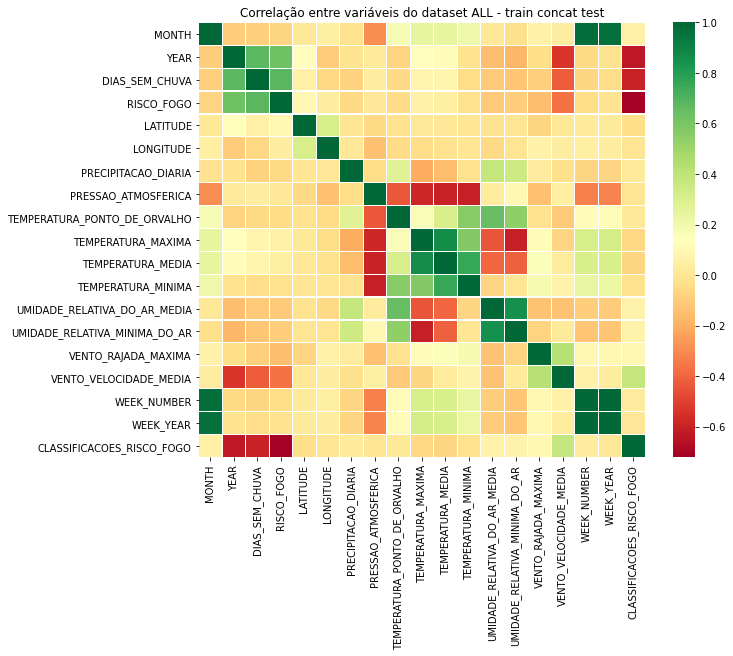

In [26]:
# variáveis não muito correlatas - melhor valor SibSp e Parch / Fare e Survived
sns.heatmap(Queimadas_Pantanal.corr(method = 'spearman'),cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Correlação entre variáveis do dataset ALL - train concat test')
plt.show()

In [76]:
target = ['CLASSIFICACOES_RISCO_FOGO']
cat_columns = ['CIDADE']
num_columns = ['MONTH', 'YEAR','DIAS_SEM_CHUVA','RISCO_FOGO','PRECIPITACAO_DIARIA','PRESSAO_ATMOSFERICA','TEMPERATURA_PONTO_DE_ORVALHO','TEMPERATURA_MAXIMA','TEMPERATURA_MEDIA','TEMPERATURA_MINIMA','UMIDADE_RELATIVA_DO_AR_MEDIA','UMIDADE_RELATIVA_MINIMA_DO_AR','VENTO_RAJADA_MAXIMA','VENTO_VELOCIDADE_MEDIA']

In [67]:
# Associação de Variáveis
Queimadas_Pantanal[num_cols+target].corr()['CLASSIFICACOES_RISCO_FOGO']

MONTH                            0.037077
YEAR                            -0.649036
DIAS_SEM_CHUVA                  -0.331342
RISCO_FOGO                      -0.728449
PRECIPITACAO_DIARIA             -0.028817
PRESSAO_ATMOSFERICA             -0.045979
TEMPERATURA_PONTO_DE_ORVALHO    -0.015812
TEMPERATURA_MAXIMA              -0.091329
TEMPERATURA_MEDIA               -0.098860
TEMPERATURA_MINIMA              -0.045873
UMIDADE_RELATIVA_DO_AR_MEDIA     0.069760
UMIDADE_RELATIVA_MINIMA_DO_AR    0.067535
VENTO_RAJADA_MAXIMA              0.090996
VENTO_VELOCIDADE_MEDIA           0.357027
CLASSIFICACOES_RISCO_FOGO        1.000000
Name: CLASSIFICACOES_RISCO_FOGO, dtype: float64

In [13]:
Queimadas_Pantanal.to_csv('Queimadas_Pantanal.csv', index=False)

In [14]:
Queimadas_Pantanal = pd.read_csv('Queimadas_Pantanal.csv')

In [15]:
Queimadas_Pantanal.head()

,CIDADE,DATE,MONTH,YEAR,DIAS_SEM_CHUVA,RISCO_FOGO,LATITUDE,LONGITUDE,PRECIPITACAO_DIARIA,PRESSAO_ATMOSFERICA,...,TEMPERATURA_MEDIA,TEMPERATURA_MINIMA,UMIDADE_RELATIVA_DO_AR_MEDIA,UMIDADE_RELATIVA_MINIMA_DO_AR,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_MEDIA,CLASSIFICACOES_RF,WEEK_NUMBER,WEEK_YEAR,CLASSIFICACOES_RISCO_FOGO
0,CORUMBA,2010-01-04,1,2010,0.0,0.0,-18.091,-55.493,0.0,996.17,...,28.04,25.2,82.95,60,9.5,1.4,Mínimo,1,12010,4
1,CORUMBA,2010-01-04,1,2010,0.0,0.0,-18.091,-55.493,0.0,996.17,...,28.04,25.2,82.95,60,9.5,1.4,Mínimo,1,12010,4
2,CORUMBA,2010-01-16,1,2010,0.0,0.0,-19.654,-57.829,0.0,996.17,...,28.04,25.2,82.95,51,6.8,1.4,Mínimo,2,22010,4
3,CORUMBA,2010-01-16,1,2010,0.0,0.0,-19.668,-57.826,0.0,996.17,...,28.04,25.2,82.95,51,6.8,1.4,Mínimo,2,22010,4
4,CORUMBA,2010-01-17,1,2010,0.0,0.0,-18.323,-57.520,13.4,996.17,...,28.04,25.8,74.00,59,6.1,1.4,Mínimo,2,22010,4


In [34]:
Queimadas_Pantanal['DATE'] = pd.to_datetime(Queimadas_Pantanal['DATE'])